# Lecture #8: Metropolis-Hastings and Gibbs
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2021

<img src="fig/logos.jpg" style="height:150px;">

In [1]:
### Import basic libraries
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Outline
1. MCMC Samplers: Metropolis-Hastings and Gibbs
2. MCMC Diagnostics
3. A Review of Statistical Modeling Thus Far

## Motivation

Last time, we'd argued intuitively that the Gibbs sampler is a type of MCMC sampler, but we did not prove it. 

Today, rather than directly proving that Gibbs is an MCMC sampler, we describe a more general type of MCMC sampler, the Metropolis-Hastings sampler, and show that the Gibbs sampler is a special case of Metropolis-Hastings.

<img src="fig/gibbs2.jpg" style="height:350px;">

# Markov Chain Monte Carlo

## Markov Chain Monte Carlo Samplers

Every sampler for a distribution $p(\theta)$ over the domain $\Theta$ defines a stochastic process $\{X_0, X_1, \ldots, \}$, where the state space is $\Theta$.

If the sampler defines a Markov chain whose unique stationary and limiting distribution is $p$, we call it a ***Markov Chain Monte Carlo (MCMC)*** sampler.

That is, for every MCMC sampler, we have that 
1. **Stationary:** $pT = p$<br><br>

2. **Limiting:** $\underset{n\to \infty}{\lim} \pi^{(n)} = p$, for any $\pi^{(0)}$

where $T$ is the transition matrix or kernel pdf defined by the sampler.

## What Do We Need to Prove to get $pT=p$ and $\underset{n\to \infty}{\lim} \pi^{(n)} = p$?

1. Prove that the sampler is ***irreducible*** and ***aperiodic***. Then, there is a unique stationary distribution $\pi$ such that 
$$\pi T = \pi.$$

2. Prove that the sampler is ***reversible*** or ***detailed balanced*** with respect to $p$. Then, 
$$\pi = p.$$

## Metropolis-Hastings: The Idea

The Metropolis-Hastings algorithm is similar to rejection sampling, but rather than sampling from a proposal distribution $q$ over the entire domain, we use the proposal distribution to sample a point close to the last sample. If the proposed sample has higher likelihood than the current under the target pdf $p$ then we are more likely to accept it as a sample from $p$. 

Rather than making global "jumps" or proposals that may be very unlikely under $p$, we make a series of smaller local "jumps".

<img src="fig/mh.jpg" style="height:350px;">

## Metropolis-Hastings: The Algorithm

For a target distribution $p(\theta)$ over $\Theta$ and a proposal distribution $q(\theta | \theta_{\text{old}})$ over $\Theta$, the ***Metropolis-Hastings (MH) algorithm*** is a MCMC algorithm for generating samples from $p$.

1. **Step 0:** choose an initial value $\theta_0 \in \Theta$.
2. **Step 1:** repeat for $S$ number of steps:
  - **Proposal:** propose a sample $\theta_{\text{prop}} \sim q(\theta | \theta_{\text{old}})$
  - **Accept/Reject:** 
    - generate $U \sim U(0, 1)$
    - generate accept "probability": 
    $$\alpha(\theta_{\text{prop}}, \theta_{\text{old}}) = \min\left(1, \frac{p(\theta_{\text{prop}})/q(\theta_{\text{prop}} | \theta_{\text{old}})}{p(\theta_{\text{old}})/ q(\theta_{\text{old}}| \theta_{\text{prop}})}\right)$$
    - if $U < \alpha(\theta_{\text{prop}}, \theta_{\text{old}})$: 
      - add $\theta_{\text{prop}}$ to list of accepted samples
      - set $\theta_{\text{old}} \leftarrow \theta_{\text{prop}}$ 
    - else: 
      add $\theta_{\text{old}}$ to list of accepted samples


## Metropolis-Hastings: Proof of Correctness

We want to show that the Metropolis Hastings algorithm defines a Markov Chain, $\theta_0, \theta_1, \ldots$, with a unique stationary distribution $p$ and that the chain converges to $p$ regardless of initialization. So we need:
1. MH defines an **irreducible** chain: a sufficient condition is that for any $\theta' \in \Theta$

$$
q(\theta| \theta') > 0,\; \text{for all } \theta \in \Theta.
$$

2. MH defines an **aperiodic** chain: a sufficient condition is that for any $\theta' \in \Theta$

$$
q(\theta | \theta') > 0, \text{for all $\theta$ is a small neighbourhood around $\theta'$}.
$$

3. MH defines an **reversible** chain (i.e. **detailed balance** is satisfied) with respect to $p$:

$$
p(\theta')T_{\text{MH}}(\theta', \theta) = T_{\text{MH}}(\theta, \theta') p(\theta)
$$

where $T_{\text{MH}}$ is transition kernel pdf of the MH sampler.

## Metropolis-Hastings: Proof of Detailed Balance
Recall that the transition kernel pdf $T_{\text{MH}}(\theta, \theta')$ is the likelihood of the MH sampler transitioning from $\theta$ to $\theta'$. When $\theta \neq \theta'$, the MH transition kernel pdf is, written a more friendly way, using $T_{\text{MH}}(\theta' | \theta)$ to denote transitioning from $\theta$ to $\theta'$:

$$
T_{\text{MH}}(\theta | \theta') = \underbrace{q(\theta| \theta')}_{\text{likelihood of proposing $\theta$}}\;\;\underbrace{\alpha(\theta, \theta')}_{\text{probability of accepting $\theta$}}.
$$

Now, we can show:
\begin{aligned}
p(\theta')T_{\text{MH}}(\theta| \theta') &= p(\theta')q(\theta| \theta')\alpha(\theta, \theta')\\
&= p(\theta')q(\theta| \theta')\min\left(1, \frac{p(\theta)q(\theta'|\theta)}{p(\theta')q(\theta|\theta')}\right)\\
&= \min\left(p(\theta')q(\theta| \theta'), \frac{p(\theta)q(\theta'|\theta)p(\theta')q(\theta| \theta')}{p(\theta')q(\theta|\theta')}\right)\\
&= \min\left(p(\theta')q(\theta| \theta'), p(\theta)q(\theta'|\theta)\right)\\
&= p(\theta)q(\theta'|\theta)\min\left(\frac{p(\theta')q(\theta| \theta')}{p(\theta)q(\theta'|\theta)}, 1\right)\\
&= p(\theta)q(\theta'|\theta)\alpha(\theta', \theta)\\
&= T_{\text{MH}}(\theta'| \theta) p(\theta)
\end{aligned}


## Gibbs as Metropolis-Hastings
Now we are ready to prove the correctness of Gibbs sampling, by realizing it as a special instance of Metropolis-Hastings sampling.

Let $\theta \in \mathbb{R}^D$. Let's define the proposal distribution $q(\theta_{\text{new}}|\theta_{\text{old}})$ as a two stage process:
1. propose an integer $d \in [1, D]$ uniformly
2. propose $\theta_{\text{new}}$ where $\theta_{d, \text{new}} \sim p(\theta_d | \theta_{-d, \text{old}})$ and $\theta_{-d, \text{new}} = \theta_{-d, \text{old}}$

where $\theta_d$ is the $d$-th component of $\theta$ and $\theta_{-d} = [\theta_1, \ldots, \theta_{d-1}, \theta_{d+1}, \ldots, \theta_D]$.

Then the acceptance probability is:

\begin{aligned}
\min\left(1, \frac{p(\theta_{\text{new}})q(\theta_{\text{old}}|\theta_{\text{new}})}{p(\theta_{\text{old}})q(\theta_{\text{new}}|\theta_{\text{old}})} \right) &= \min\left(1, \frac{p(\theta_{d, \text{new}}|\theta_{-d, \text{new}})p(\theta_{-d, \text{new}}) p(\theta_{d, \text{old}} | \theta_{-d, \text{new}})}{p(\theta_{d, \text{old}}|\theta_{-d, \text{old}})p(\theta_{-d, \text{old}}) p(\theta_{d, \text{new}} | \theta_{-d, \text{old}})} \right)\\
&= \min\left(1, \frac{p(\theta_{d, \text{new}}|\theta_{-d, \text{old}})p(\theta_{-d, \text{old}}) p(\theta_{d, \text{old}} | \theta_{-d, \text{new}})}{p(\theta_{d, \text{old}}|\theta_{-d, \text{new}})p(\theta_{-d, \text{old}}) p(\theta_{d, \text{new}} | \theta_{-d, \text{old}})} \right)\\
&= \min\left(1, 1\right) = 1
\end{aligned}

in the second to last equality, we make use of the fact that $\theta_{-d, \text{new}} = \theta_{-d, \text{old}}$. That is, Gibbs sampling is a MH algorithm with 100% acceptance rate.

# Simple MCMC Diagnostics

## Traceplot Checks for Mixing

Reversibility, irreducibility and aperiodicity gaurantee that as the number of iterations $S$ approaches infinity, the sampler will be sampling from the target distribution $p$. In practice, getting sufficiently close to convergence, or ***mixing***, may take a very large number of steps. 

A quick and intuitive way to check for mixing is by visualizing the ***traceplots*** of each dimension of the samples over iterations.  That is, for each dimension of the samples, we plot the sampled values of that dimension against the iteration number.

<img src="fig/mixing.jpg" style="height:120px;">

## Burn-in and Thinning

**When initialization is the problem:** when you initialize your sampler far from any regions of high probability mass, the initial samples produced by your sampler will have a trend -- they will move sequentially towards an area in the sample space $\Theta$ where the target distribution $p$ has high mass. 

This problem can be mitigated by discarding $B$ number of initial samples, this chunk of samples is called the ***burn-in***. 

**When high spatial correlation is the problem:** for Metropolis-Hastings, when your proposal distirbution has very low variance the proposed sample will be very close to the current sample. This results in higher correlations between consecutive samples in your chain. 

This problem can be mitigated by discarding every $T$ number of samples, this is called ***thinning***. The rational is that every sample might be correlated with $T$ number of samples immediately preceeding or suceeding it, but its correlation with samples greater than $T$ steps away from it will be much smaller.



## Example: Sampling from a Mixture of Two Gaussians

In [2]:
#implementation of metropolis-hastings with symmetric proposal distribution
def MH_sampler(S, target, init, sigma_sq=0.5):
    samples = []
    current = init
    accepts = 0
    for s in range(S):
        proposal = np.random.normal(current, sigma_sq**2)
        U = np.random.uniform(0, 1)
        
        if U < np.min((1, target(proposal) / target(current))):
            samples.append(proposal)
            current = proposal
            accepts += 1
        else:
            samples.append(current)
    
            
    return samples, accepts * 1. / S

#visualize target distribution and samples
def plot_samples(ax, target, samples, title):
    x = np.linspace(-5, 25, 100)
    ax.plot(x, target(x), color='black', alpha=0.9, label='target distribution')
    ax.hist(samples, density=True, bins=50, color='red', alpha=0.5, label='all samples')
    ax.set_title(title)
    ax.legend(loc='best')
    return ax

#define the target distribution as a mixture of two univariate gaussians
sigma_sqs = [1, 1]
mus = [2, 20]
pis = [0.5, 0.5]
target = lambda x: pis[0] * sp.stats.norm(mus[0], sigma_sqs[0]**0.5).pdf(x) + pis[1] * sp.stats.norm(mus[1], sigma_sqs[1]**0.5).pdf(x)

In [3]:
#total number of samples
S = 5000
#initialization of the MH sampler
init = -10
#amount of samples to throw out
burn_in = 1000
#keep every n samples
thinning = 5
#sample from the MH sampler
samples, accepts = MH_sampler(S, target, init)

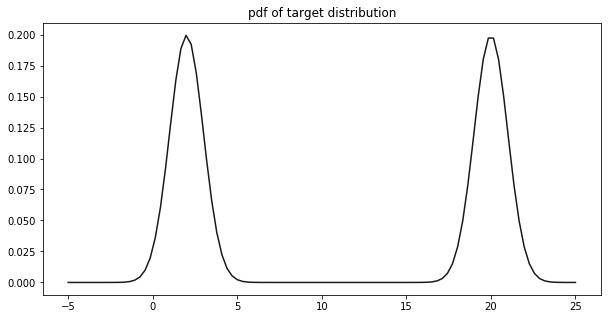

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(-5, 25, 100)
ax.plot(x, target(x), color='black', alpha=0.9)
ax.set_title('pdf of target distribution')
plt.show()

## Visual Checks for Mixing

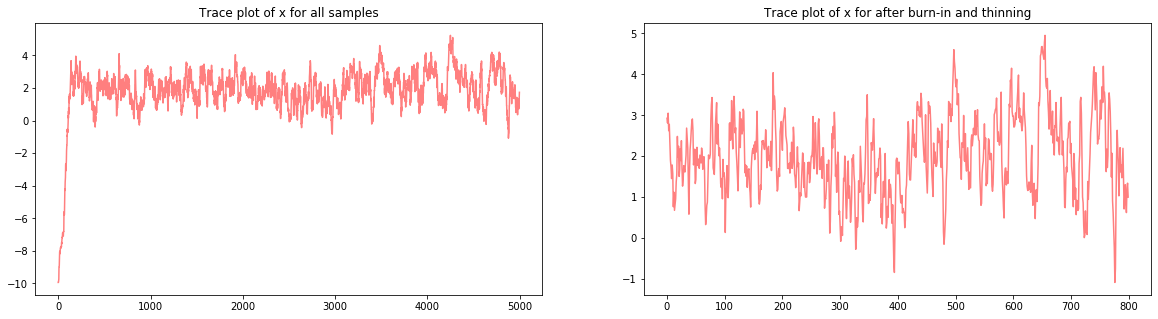

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(range(S), samples, color='red', alpha=0.5)
ax[0].set_title('Trace plot of x for all samples')
ax[1].plot(range(len(samples[burn_in::thinning])), samples[burn_in::thinning], color='red', alpha=0.5)
ax[1].set_title('Trace plot of x for after burn-in and thinning')
plt.show()

## Visual Checks Can be Misleading

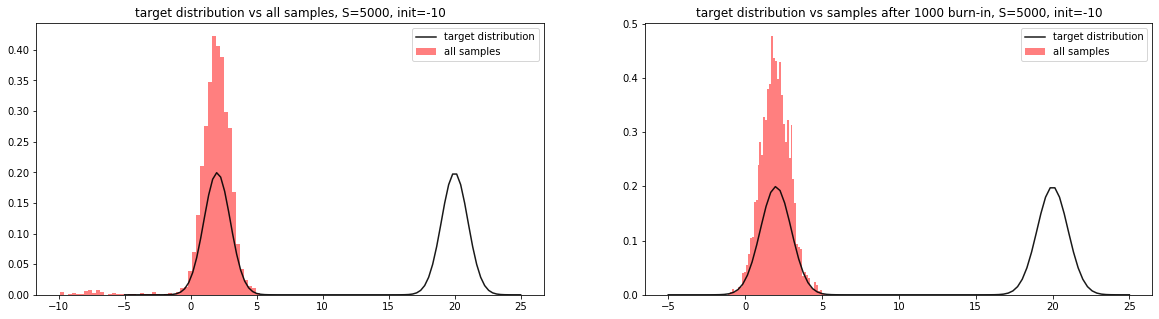

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0] = plot_samples(ax[0], target, samples, 'target distribution vs all samples, S={}, init={}'.format(S, init))
ax[1] = plot_samples(ax[1], target, samples[200:], 'target distribution vs samples after {} burn-in, S={}, init={}'.format(burn_in, S, init))
plt.show()

## The Importance of Tuning Your Sampler
Our Metropolis-Hastings sampler was unable to capture both modes in the target distribution!

Is this because this algorithm is incapable of sampling from this specific distribution of this class of ***multimodal distributions***? Or did we make inappropriate design choices when we specified our sampler?

**Question:** we've demonstrated that visualizing the traceplot may be a poor metric for evaluating MCMC performance. Is there a better way to check if our MCMC chain has mixed? In particular, how do we detect that there is still a high-likelihood region in the domain $\Theta$ that the sampler has yet to visit?

# More MCMC Diagnostics and Best Practices

## More Rigorous Checks for Convergence

Look for:
1. Large segments of the ***chain*** (sequence of samples) should have give similar statistics (mean, variance etc)
2. Low correlations within states of the chain
3. "Reasonably high" acceptance rate of proposed steps
4. Multiple chains initialized from different initial points give similar results

Best practics:
1. Always run multiple chains initialized from very different random starting points
2. Always run your chains for as long as you can then burn and thin
3. Always check all relevant convergence diagnostics
4. Never be too certain: remember that there is no "proof" of convergence for finite chains!
5. Keep reading about best practice!

## Visual Diagnostics: Traceplots of Multiple Chains

<img src="fig/multichain.jpg" style="height:400px;">

## Autocorrelation: the "Effective" Sample Size

We quantify how much the samples in the chain are correlated with the samples obtained $k$-steps later (**the $k$-th lag**). The ***autocorrelation*** $\rho_k$ is defined as

$$
\rho_k = \frac{\sum_{n=1}^{N-k}(x_n - \bar{x})(x_{n+k} - \bar{x})}{\sum_{n=1}^{N}(x_n - \bar{x})^2}
$$

We plot the autocorrelation for each $k = 1, \ldots, \frac{N}{2}$, and this ***autocorrelation plot*** tells us how much we to thin in order to obtain effectively independent samples. The autocorrelation plot gives us an idea of the ***effective sample size*** of the Markov chain.

## Visual Diagnostics: The Autocorrelation Plot

<img src="fig/autocorr.jpg" style="height:400px;">

## Quantitative Diagnostics

**Idea:** measure between-chain and within-chain variability of a quantity of interest – if the chains have converged, these measures will be similar; otherwise, the between-chain variability will be larger.

1. ***Gelman & Rubin***: quantity $\widehat{R}_{\text{GR}} =  \frac{B}{W}$, which compares $B$ the empirical variance of all the chains pooled and $W$ the average emprical variance within each chain. If $\widehat{R}_{\text{GR}}$ is large then the chains are very different (not converged). If $\widehat{R}_{\text{GR}} = 1$ is ideal but in practice we accept $\widehat{R}_{\text{GR}} < 1.05$.<br><br>

2. ***Geweke***: takes two nonoverlapping parts (usually the first 0.1 and last 0.5 proportions) of the Markov chain and compares the means of both parts, using a difference of means test to see if the two parts of the chain are from the same distribution (the test statistic is a standard Z-score with the standard errors adjusted for autocorrelation).

# Review of Statistical Modeling

## What We Can Do So Far
1. **(Models)** When we have observed data $Y_{\text{Obs}}$, we can model $Y_{\text{Obs}}$ as a random variable $Y_{\text{Obs}} \sim p(Y |\theta)$ with a known distribution $p$.
  - if $Y_{\text{Obs}}$ is a label, we can model it as a *Categorical* or *Bernoulli* variable
  - if $Y_{\text{Obs}}$ is a count, we can model it as a *Binomial*, *Multinomial* or *Poisson*
  - if $Y_{\text{Obs}}$ is continuous, we can model it as a *Gaussian*, *Exponential*, *Dirichlet* etc
 
2. **(Inference)** We can make statements about $\theta$ by performing:
   - ***Maximum Likelihood Estimation:*** compute a fixed value $\theta_{\text{MLE}}$ that maximizes the likelihood of the observed data $Y$.
   - ***Bayesian Inference:*** *assume* a prior for $\theta$, encoding our knowledge and uncertainty about $\theta$, then compute the posterior $p(\theta| Y)$ distribution. 
   
3. **(Inference Algorithm)** We choose an algorithm to perform inference:

  - ***Maximum Likelihood Estimation:*** *analytically* solve an unconstrained or contrained optimization problem to obtain $\theta_{\text{MLE}}$.
  - ***Bayesian Inference:*** 
    - if the prior and likelihood are ***conjugate***, then *analytically* derive the posterior distribution
    - if the posterior distribution does not have a known (to you) form, sample from it using a ***sampler***.
    

## What Happens After Inference?

1. **(Predictive Evaluation)** In practice, we do not know the true model $\theta_{\text{True}}$! Thus, $\theta_{\text{MLE}}$ and $p(\theta|Y)$ cannot be evaluated by comparison to $\theta_{\text{True}}$.
  - ***Maximimum Likelihood Estimation:*** we sample multiple $Y \sim p(Y| \theta_{\text{MLE}})$ and compare with observed data $Y_{\text{Obs}}$.
  - ***Bayesian Inference:*** we sample multiple $Y$ from the ***posterior predictive*** and compare with observed data $Y_{\text{Obs}}$.<br><br>

2. **(Uncertainty Evaluation)** Before making decisions with real-life consequence based on your model, you should check the precision of your estimate or uncertainty of you model.
  - ***Maximimum Likelihood Estimation:*** repeat the MLE computation on many bootstrap samples of $Y_{\text{Obs}}$. Compute the confidence interval of $\theta$ and the predictive interval for $Y$. These intervals indicate *precision*.
  - ***Bayesian Inference:*** Compute credible intervals for the posterior $p(\theta|Y)$ and the predictive intervals of the posterior predictive. These intervals indicate *model uncertainty*.

## The Modeling Process

<img src="fig/modeling.jpg" style="height:250px;">